In [1]:
import pandas as pd
import re
from sklearn.model_selection import ShuffleSplit
import numpy as np

merged_data = pd.read_csv("merged_dataset.csv",index_col=False)
drug_data =  pd.read_csv("morgan_fp_drug_128.csv")
protein_data =  pd.read_csv("protein_desc_mutant.csv")


In [2]:
merged_data = merged_data.merge(drug_data, left_on=['drug'], right_on=['drug'])
merged_data = merged_data.merge(protein_data, left_on=['mutant'], right_on=['mutant'])
df = merged_data.iloc[:,1:]

Epoch [1/1000], Loss: 0.0174, Train Accuracy: 0.3281, Test Accuracy: 0.3727
Epoch [11/1000], Loss: 0.0127, Train Accuracy: 0.7422, Test Accuracy: 0.7545
Epoch [21/1000], Loss: 0.0115, Train Accuracy: 0.8438, Test Accuracy: 0.7636
Epoch [31/1000], Loss: 0.0113, Train Accuracy: 0.8477, Test Accuracy: 0.8364
Epoch [41/1000], Loss: 0.0109, Train Accuracy: 0.8633, Test Accuracy: 0.8545
Epoch [51/1000], Loss: 0.0109, Train Accuracy: 0.8672, Test Accuracy: 0.8545
Epoch [61/1000], Loss: 0.0108, Train Accuracy: 0.8516, Test Accuracy: 0.8545
Epoch [71/1000], Loss: 0.0107, Train Accuracy: 0.8789, Test Accuracy: 0.8636
Epoch [81/1000], Loss: 0.0104, Train Accuracy: 0.9023, Test Accuracy: 0.8545
Epoch [91/1000], Loss: 0.0103, Train Accuracy: 0.9062, Test Accuracy: 0.8545
Epoch [101/1000], Loss: 0.0104, Train Accuracy: 0.8984, Test Accuracy: 0.8455
Epoch [111/1000], Loss: 0.0105, Train Accuracy: 0.8828, Test Accuracy: 0.8455
Epoch [121/1000], Loss: 0.0105, Train Accuracy: 0.8906, Test Accuracy: 0.85

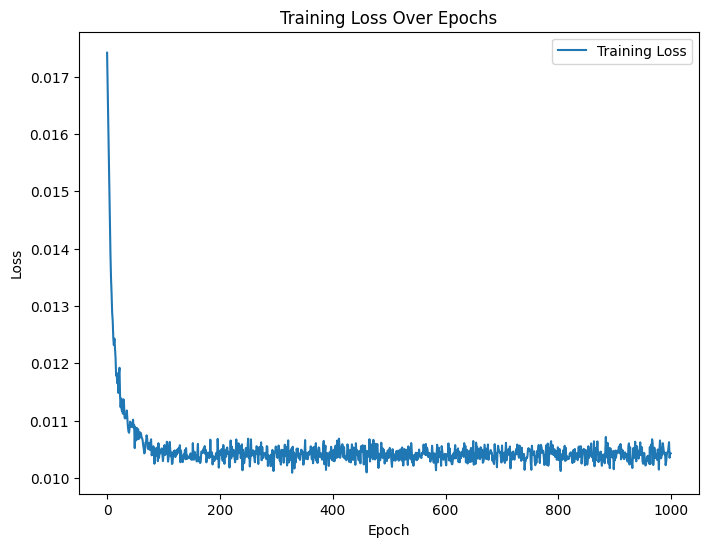

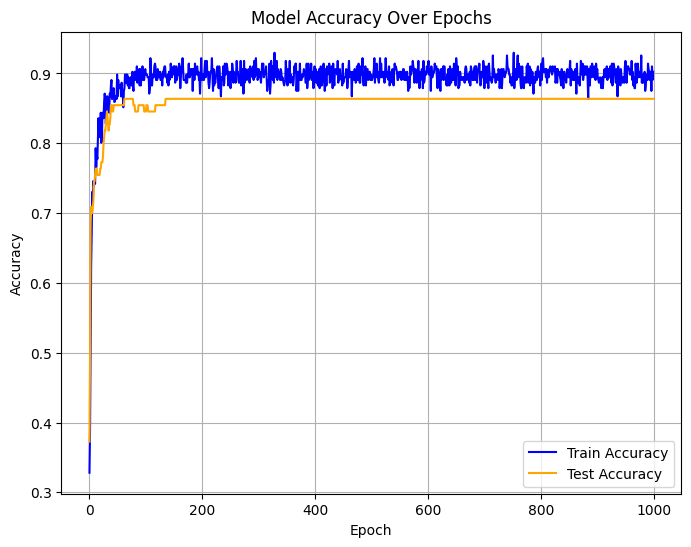

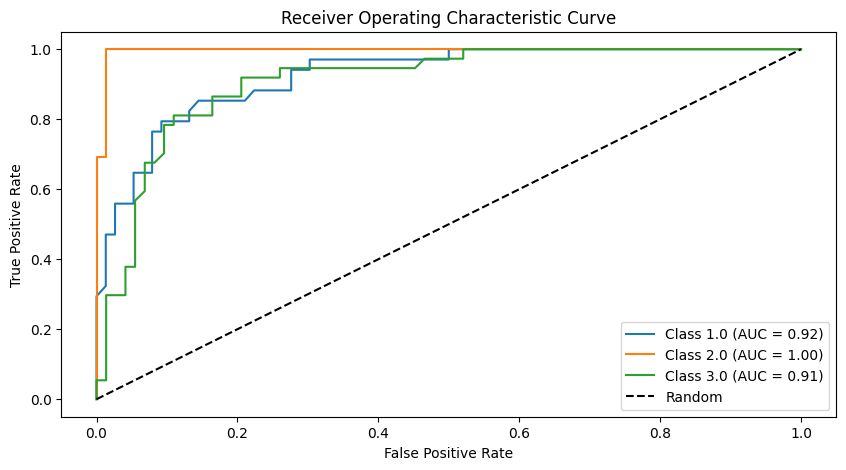

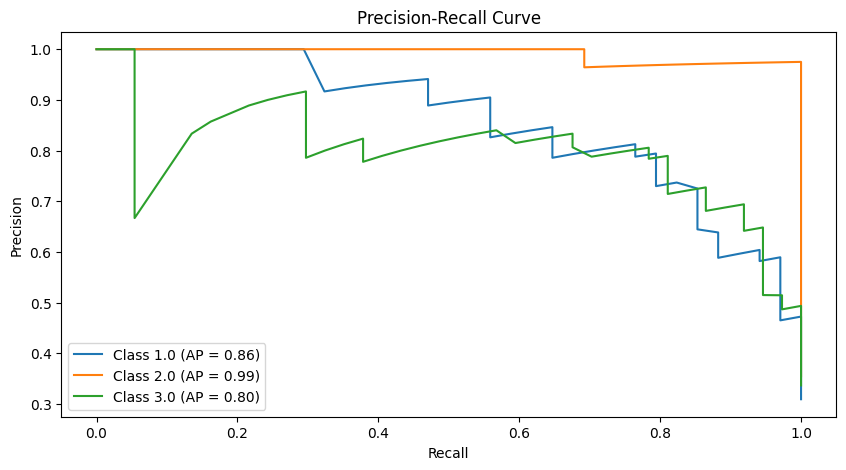

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np


X = df.iloc[:, 3:].values  
y = df['trend'].values     

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=128)
X_pca = pca.fit_transform(X_scaled)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_encoded)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

class DNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob=0.5):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], output_dim)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.dropout3 = nn.Dropout(dropout_prob)
        
        self.init_weights()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after each layer
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after each layer
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)  # Apply dropout after each layer
        x = self.fc4(x)
        return F.softmax(x, dim=1)  # Softmax for multi-class classification

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dims = [64, 32, 32]
output_dim = len(le.classes_)
learning_rate = 1e-3
batch_size = 64  
epochs = 1000
dropout_prob = 0.1  

model = DNNModel(input_dim, hidden_dims, output_dim, dropout_prob)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with gradient clipping and learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0
    for i in range(0, len(X_train), batch_size):
        # Get batch
        batch_X = torch.tensor(X_train[i:i + batch_size], dtype=torch.float32)
        batch_y = torch.tensor(y_train[i:i + batch_size], dtype=torch.long)

        optimizer.zero_grad()

        output = model(batch_X)
        
        loss = criterion(output, batch_y)
        epoch_loss += loss.item()

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        _, predicted = torch.max(output, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)

    scheduler.step()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    train_losses.append(epoch_loss / len(X_train))

    model.eval()  
    with torch.no_grad():
        test_X = torch.tensor(X_test, dtype=torch.float32)
        test_y = torch.tensor(y_test, dtype=torch.long)
        test_output = model(test_X)
        _, predicted = torch.max(test_output, 1)
        correct_test = (predicted == test_y).sum().item()
        total_test = test_y.size(0)
        test_accuracy = correct_test / total_test
        test_accuracies.append(test_accuracy)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(X_train):.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot training loss over iterations
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot accuracy over iterations
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    # Predict on test data
    all_true_labels = y_test
    all_pred_probs = model(torch.tensor(X_test, dtype=torch.float32)).cpu().numpy()

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}
for i in range(output_dim):
    fpr[i], tpr[i], _ = roc_curve(all_true_labels, all_pred_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 5))
for i in range(output_dim):
    plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve
precision = {}
recall = {}
average_precision = {}

for i in range(output_dim):
    precision[i], recall[i], _ = precision_recall_curve(all_true_labels, all_pred_probs[:, i], pos_label=i)
    average_precision[i] = average_precision_score(all_true_labels == i, all_pred_probs[:, i])

# Plot Precision-Recall curve
plt.figure(figsize=(10, 5))
for i in range(output_dim):
    plt.plot(recall[i], precision[i], label=f'Class {le.classes_[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
